# Cerv.ai: Cervical Cancer Detection from VIA Using Deep Learning Models

This notebook serves as a documentation for the dataloader and data visualization to the training of deep learning models for object detection on cervical cancer images.

## About the datasets
1. All datasets were sourced from **Roboflow** in a consistent format. The most common format would be the [COCO format](https://roboflow.com/formats/coco-json) where the bounding boxes are stored in a *JSON* file.

2. Each datasets are **above 256** pixels, hence resizing all datasets into this size will not be a problem for the model. However, resizing the dataset also means that the bounding boxes will have to be resized as well, so the same image transformation done on the image will have to be applied to the bounding boxes.

3. Two datasets will be trained separately from the other three datasets. 
    - [Cervical cancer detection through imaging Computer Vision Project](https://universe.roboflow.com/kaplan-business-school-ovqtk/cervical-cancer-detection-through-imaging) and [Cervical cancer negative Computer Vision Project](https://universe.roboflow.com/raymondnuwagaba-outlook-com/cervical-cancer-negative).
    - These datasets contain a black area on the sides, leaving the image itself as an oval. This may impede the training and as such, necessary steps must be done to train on this dataset.
    - Hence, the training will first be done on the three datasets stored in the *datasets* folder in this directory.

## Additional Notes
1. Due to the balanced nature of the datasets, this training provides **no data augmentations**. It is only when the training with the other datasets that augmentations will be applied.

# Data preparation

- Instantiating the dataset class and the dataloaders.
- Data visualization (image and bounding boxes).
- Definition of data transforms to be used.
- **Image format**: *COCO format* for scalability and clean integration with Pytorch. Supports segmentation as well.

Showing images from dataset: merged


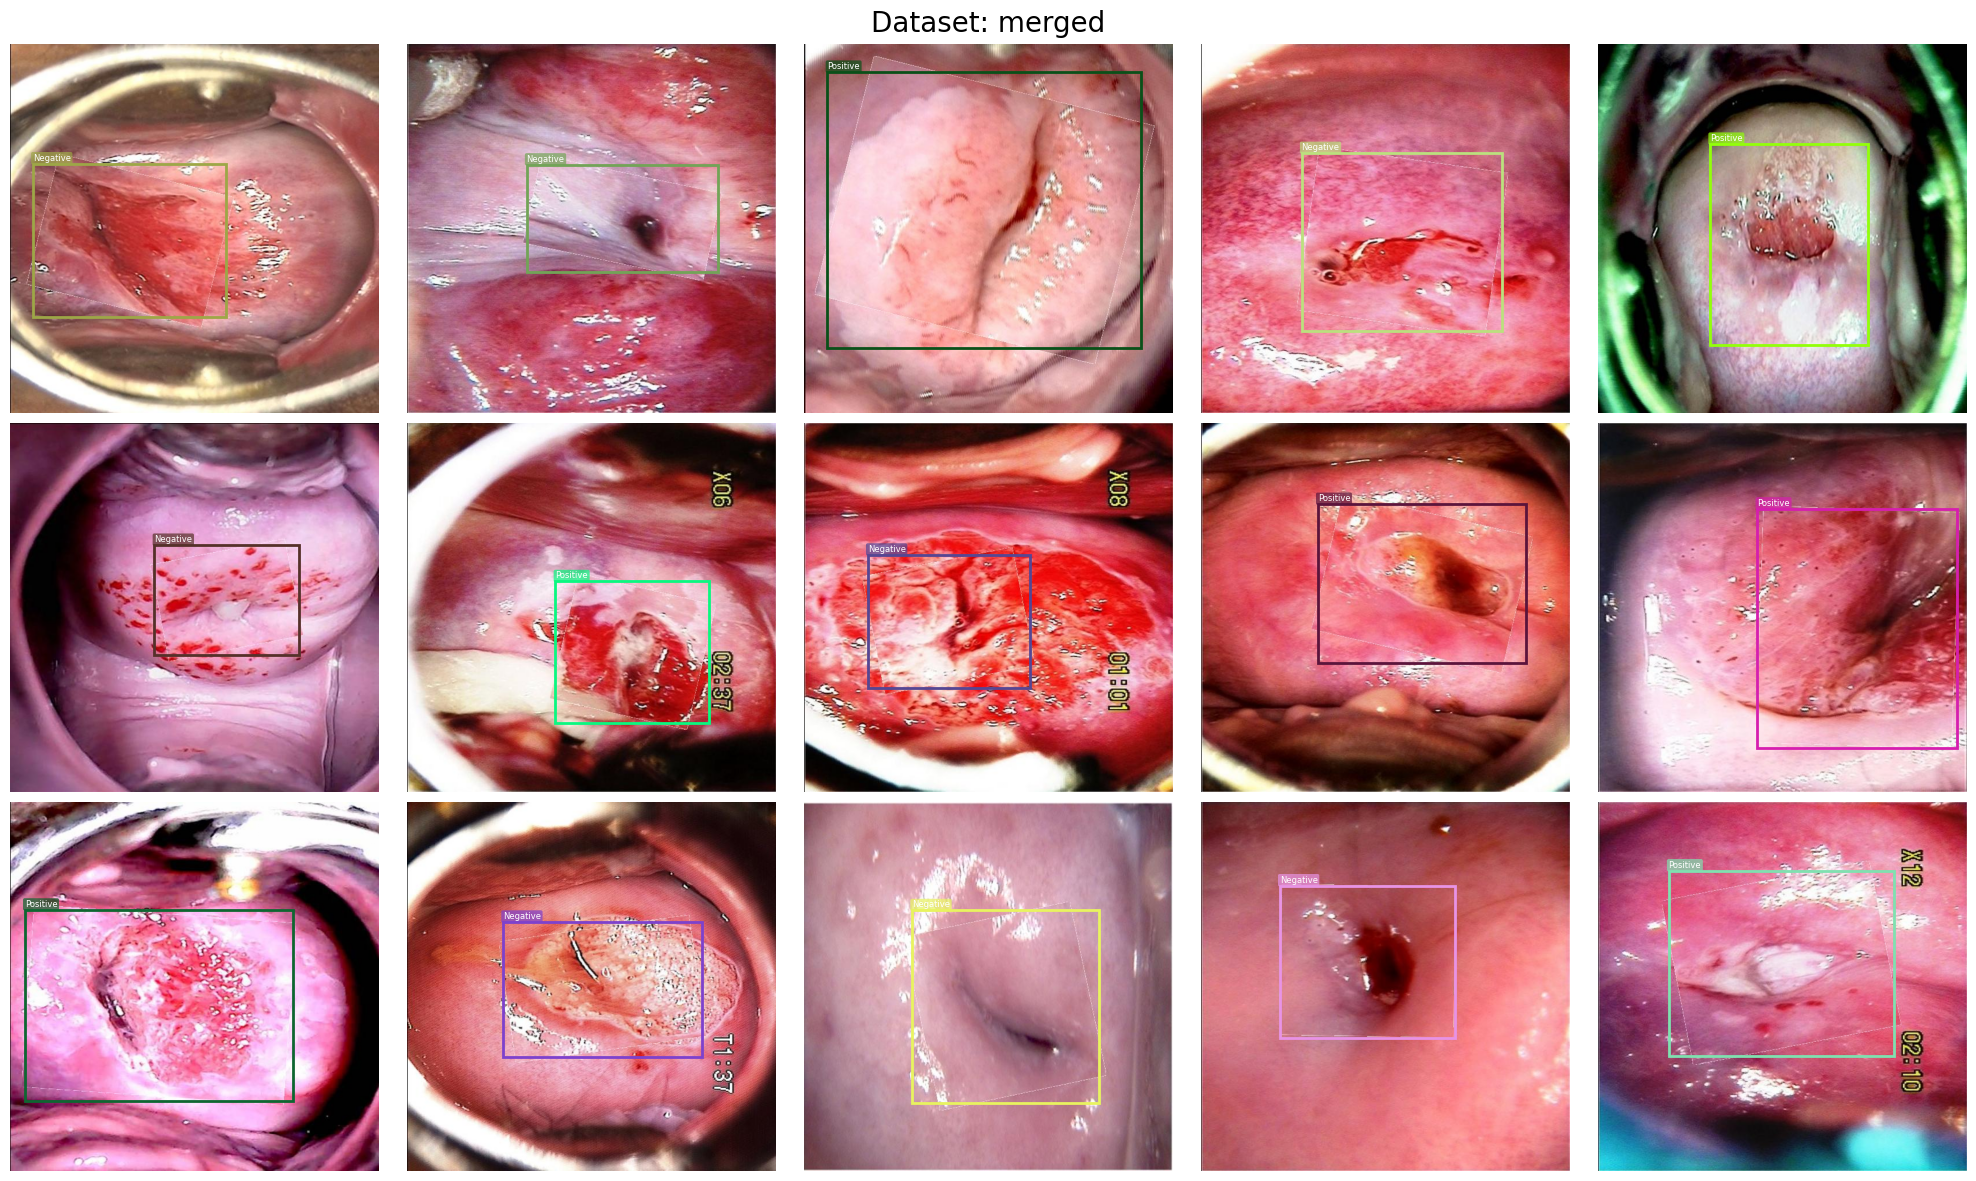

In [4]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#* Create dataset class
class COCODataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = root_dir
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
        # Load COCO annotations
        annotation_path = os.path.join(root_dir, "_annotations.coco.json")
        with open(annotation_path, "r") as f:
            coco_json = json.load(f)
        
        self.images = {img["id"]: img for img in coco_json["images"]}
        self.annotations = coco_json["annotations"]
        self.categories = {cat["id"]: cat["name"] for cat in coco_json.get("categories", [])}
        
        # Map image_id -> list of annotations
        self.img_id_to_anns = {}
        for ann in self.annotations:
            img_id = ann["image_id"]
            if img_id not in self.img_id_to_anns:
                self.img_id_to_anns[img_id] = []
            self.img_id_to_anns[img_id].append(ann)

        self.image_ids = list(self.images.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]
        img_path = os.path.join(self.image_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        annotations = self.img_id_to_anns.get(img_id, [])
        
        return image, annotations, self.categories
        

#* Create dataloader to iterate through dataset class
def build_dataloaders(base_dir,rel_path ,batch_size=1, shuffle=True):
    dataloaders = {}
    for dataset_name in os.listdir(base_dir):
        try:
            train_dir = os.path.join(base_dir, dataset_name, rel_path)
            annotation_file = os.path.join(train_dir, "_annotations.coco.json")
            if os.path.exists(train_dir) and os.path.exists(annotation_file):
                dataset = COCODataset(train_dir)
                dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=lambda x: x)
                dataloaders[dataset_name] = dataloader
        except:
            continue # skip for folders that do not exist
    return dataloaders

#* Image display function
def show_image_with_boxes(tensor_img, annotations, categories, ax):
    img = tensor_img.permute(1, 2, 0).numpy()  # C x H x W -> H x W x C
    ax.imshow(img)

    for ann in annotations:
        bbox = ann['bbox']
        category_id = ann.get("category_id", None)
        category_name = categories.get(category_id, "Unknown")
        
        color = [random.random() for _ in range(3)]
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2], bbox[3],
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)
        
        ax.text(
            bbox[0], bbox[1] - 5,
            f"{category_name}",
            color='white',
            fontsize=6,
            bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
        )
    ax.axis('off')

#* Main logic
base_dir = "datasets"
train_dataloaders = build_dataloaders(base_dir,'train')

for dataset_name, dataloader in train_dataloaders.items():
    print(f"Showing images from dataset: {dataset_name}")
    dataloader_iter = iter(dataloader)
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # 3 rows, 5 columns

    for i in range(15):  # 3x5 = 15 imagesDetection Transformer
        try:
            batch = next(dataloader_iter)
            image, annotations, categories = batch[0]
            row, col = divmod(i, 5)  # map 0..14 to grid
            show_image_with_boxes(image, annotations, categories, axes[row, col])
        except StopIteration:
            print("No more images in this dataset.")
            break

    plt.suptitle(f"Dataset: {dataset_name}", fontsize=20)
    plt.tight_layout()
    plt.show()


In [ ]:
# Count total number of images across all datasets
total_images_train = 0
for dataset_name, dataloader in train_dataloaders.items():
    dataset_size = len(dataloader.dataset)
    print(f"Dataset '{dataset_name}' contains {dataset_size} images.")
    total_images_train += dataset_size

print(f"\nTotal number of images across all datasets: {total_images_train}")


Dataset 'merged' contains 1053 images.

Total number of images across all datasets: 1053


In [ ]:

#* Initiate dataloader for test folder and get summary statistic
test_dataloaders = build_dataloaders(base_dir,rel_path='test')
total_images_test = 0
for dataset_name, dataloader in test_dataloaders.items():
    dataset_size = len(dataloader.dataset)
    print(f"Dataset '{dataset_name}' contains {dataset_size} images.")
    total_images_test += dataset_size

print(f"\nTotal number of images across all datasets: {total_images_test}")

print(f'\ntotal test size: {247/(247+1769)}')
print(f'total train size: {1769/(247+1769)}')

Dataset 'merged' contains 100 images.

Total number of images across all datasets: 100

total test size: 0.12251984126984126
total train size: 0.8774801587301587


The dataset has been divided into 88% training data and 12% testing data.

## Visualize class labels

In [25]:
for dataset_name, dataloader in train_dataloaders.items():
    print(f"Counting classes in dataset: {dataset_name}")
    dataloader_iter = iter(dataloader)
    
    # Initialize counters for positive and negative class counts
    class_counts = {category_name: 0 for category_name in dataloader.dataset.categories.values()}
    
    # Iterate over all batches in the dataset to count occurrences of each class
    for batch in dataloader:
        images, annotations, categories = batch[0]  # Unpack the batch
        
        # Count occurrences of each class for all annotations
        for ann in annotations:
            category_id = ann.get("category_id", None)
            if category_id is not None:
                category_name = categories.get(category_id, "Unknown")
                if category_name in class_counts:
                    class_counts[category_name] += 1

    # Print the class counts for the entire dataset
    print(f"Class counts for dataset {dataset_name}:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

Counting classes in dataset: merged
Class counts for dataset merged:
cancer: 0
Negative: 478
Positive: 575
Counting classes in dataset: acetic_acid_v2
Class counts for dataset acetic_acid_v2:
Normal-Abnormal: 0
Abnormal: 388
Normal: 258
Counting classes in dataset: colposcopy
Class counts for dataset colposcopy:
Normal-Abnormal: 0
Abnormal: 33
Normal: 37


In [44]:
print(*dataloader_iter)

[(tensor([[[0.4275, 0.4118, 0.4431,  ..., 0.6039, 0.5882, 0.5804],
         [0.4118, 0.3922, 0.4196,  ..., 0.6039, 0.5882, 0.5765],
         [0.4157, 0.3922, 0.4196,  ..., 0.6118, 0.5843, 0.5686],
         ...,
         [0.6588, 0.6471, 0.6314,  ..., 0.5059, 0.5255, 0.5529],
         [0.6510, 0.6431, 0.6314,  ..., 0.4980, 0.5255, 0.5569],
         [0.6353, 0.6353, 0.6275,  ..., 0.4902, 0.5255, 0.5608]],

        [[0.2314, 0.2157, 0.2510,  ..., 0.3529, 0.3373, 0.3294],
         [0.2157, 0.1961, 0.2275,  ..., 0.3529, 0.3373, 0.3255],
         [0.2235, 0.2000, 0.2275,  ..., 0.3608, 0.3333, 0.3176],
         ...,
         [0.4510, 0.4392, 0.4235,  ..., 0.3020, 0.3216, 0.3490],
         [0.4314, 0.4275, 0.4235,  ..., 0.2941, 0.3216, 0.3529],
         [0.4157, 0.4157, 0.4196,  ..., 0.2863, 0.3216, 0.3569]],

        [[0.1020, 0.0863, 0.1216,  ..., 0.1725, 0.1647, 0.1569],
         [0.0863, 0.0667, 0.0980,  ..., 0.1725, 0.1647, 0.1529],
         [0.0941, 0.0706, 0.0980,  ..., 0.1804, 0.1608, 

# The ACTUAL DataLoader

The actual dataloader class should:
1. Not expose the subfolders of the given training data.
2. If it belongs to the `merged` dataset, it should relabel its categories to match those of the other two datasets.
3. The model would label `Normal` as class 0 and `Abnormal` as class 1.

Therefore, the dataset class and Dataloaders below is used to be appropriate to training a deep learning model:

In [45]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#* Define standard class name mapping
dataset_class_name_mapping = {
    "merged": {
        "Negative": "Normal",
        "Positive": "Abnormal",
        "cancer": "Abnormal" 
    }
}

#* Define the standard class-to-label encoding
standard_label_encoding = {
    "Normal": 0,
    "Abnormal": 1
}

# Create dataset class
class COCODataset(Dataset):
    def __init__(self, root_dirs, data_type="train", transform=None):
        """
        Args:
            root_dirs (list): List of root directories of different datasets
            data_type (str): Either 'train' or 'test', specifies which subfolder to load
            transform (callable, optional): A function/transform to apply to the images
        """
        self.root_dirs = root_dirs
        self.data_type = data_type
        self.transform = transform or transforms.Compose([transforms.ToTensor()])

        self.images = []
        self.annotations = []
        self.img_id_to_path = {}

        # Load data from the specified folder (train/test)
        for root_dir in self.root_dirs:
            dataset_dir = os.path.join(root_dir, self.data_type)
            annotation_path = os.path.join(dataset_dir, "_annotations.coco.json")
            
            if os.path.exists(dataset_dir) and os.path.exists(annotation_path):
                with open(annotation_path, "r") as f:
                    coco_json = json.load(f)

                # Add image and annotation data to the lists
                self.images.extend(coco_json["images"])
                self.annotations.extend(coco_json["annotations"])

                # Map image ids to file paths (for all datasets)
                for img in coco_json["images"]:
                    self.img_id_to_path[img["id"]] = os.path.join(dataset_dir, img["file_name"])

        self.img_id_to_anns = {}
        for ann in self.annotations:
            img_id = ann["image_id"]
            if img_id not in self.img_id_to_anns:
                self.img_id_to_anns[img_id] = []
            self.img_id_to_anns[img_id].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info["id"]
        img_path = self.img_id_to_path[img_id]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        annotations = self.img_id_to_anns.get(img_id, [])
        
        return image, annotations

# Create dataloader to iterate through dataset class
def build_dataloaders(base_dirs, data_type="train", batch_size=1, shuffle=True):
    """
    Builds dataloaders for either 'train' or 'test' dataset.

    Args:
        base_dirs (list): List of base directories of different datasets.
        data_type (str): Either 'train' or 'test' specifying the data to load.
        batch_size (int): Batch size for dataloading.
        shuffle (bool): Whether to shuffle the dataset.
    
    Returns:
        dataloaders (dict): Dictionary of dataloaders for the specified data type.
    """
    dataset = COCODataset(root_dirs=base_dirs, data_type=data_type)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

base_dirs = ["datasets/acetic_acid_v2", "datasets/colposcopy", "datasets/merged"]
train_dataloader = build_dataloaders(base_dirs, data_type="train")


In [ ]:
for dataset_name, dataloader in train_dataloaders.items():
    print(f"Counting classes in dataset: {dataset_name}")
    
    dataloader_iter = iter(dataloader)

    # Apply dataset-specific name corrections
    class_name_map = dataset_class_name_mapping.get(dataset_name, {})

    # Initialize counters
    class_counts = {"Normal": 0, "Abnormal": 0}

    for batch in dataloader:
        images, annotations, categories = batch[0]  # Unpack

        for ann in annotations:
            category_id = ann.get("category_id", None)
            if category_id is not None:
                raw_category_name = categories.get(category_id, "Unknown")

                # Remap using dataset-specific mapping if exists
                mapped_category_name = class_name_map.get(raw_category_name, raw_category_name)

                # Only count if mapped name is in standard labels
                if mapped_category_name in class_counts:
                    class_counts[mapped_category_name] += 1

    # Final output
    print(f"Class counts for dataset {dataset_name}:")
    for class_name, count in class_counts.items():
        label = standard_label_encoding[class_name] 
        print(f"{class_name} (Label {label}): {count}")

Counting classes in dataset: merged
Class counts for dataset merged:
Normal (Label 0): 478
Abnormal (Label 1): 575
Counting classes in dataset: acetic_acid_v2
Class counts for dataset acetic_acid_v2:
Normal (Label 0): 258
Abnormal (Label 1): 388
Counting classes in dataset: colposcopy
Class counts for dataset colposcopy:
Normal (Label 0): 37
Abnormal (Label 1): 33


In [49]:
print(*iter(dataloader))

[(tensor([[[0.4235, 0.4627, 0.5137,  ..., 0.7373, 0.7569, 0.7412],
         [0.4275, 0.4706, 0.5255,  ..., 0.7412, 0.7725, 0.7686],
         [0.4353, 0.4784, 0.5412,  ..., 0.7529, 0.7804, 0.7804],
         ...,
         [0.7020, 0.7216, 0.7412,  ..., 0.6275, 0.5725, 0.5529],
         [0.6902, 0.7137, 0.7412,  ..., 0.6235, 0.5804, 0.5686],
         [0.6824, 0.7020, 0.7333,  ..., 0.6235, 0.6000, 0.5882]],

        [[0.2980, 0.3255, 0.3451,  ..., 0.4667, 0.4941, 0.4784],
         [0.3020, 0.3333, 0.3569,  ..., 0.4706, 0.5098, 0.5059],
         [0.3098, 0.3412, 0.3725,  ..., 0.4824, 0.5176, 0.5176],
         ...,
         [0.5176, 0.5216, 0.5176,  ..., 0.4902, 0.4118, 0.3843],
         [0.5059, 0.5137, 0.5176,  ..., 0.4706, 0.4039, 0.3843],
         [0.4980, 0.5020, 0.5098,  ..., 0.4627, 0.4157, 0.3961]],

        [[0.2000, 0.2157, 0.2118,  ..., 0.3059, 0.3294, 0.3137],
         [0.2039, 0.2235, 0.2235,  ..., 0.3098, 0.3451, 0.3412],
         [0.2118, 0.2314, 0.2392,  ..., 0.3216, 0.3490, 